# Analyze data
#### Authors: Eugenio Fella, Matteo Pedrazzi, Gaetano Ricucci and Carlo Sgorlon Gaiatto

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from matplotlib.font_manager import FontProperties

In [ ]:
# fix the seed for reproducibility
seed = 12345
np.random.seed(seed)
tf.random.set_seed(seed)

### Load dataset

[ 42.96160928 -18.36244454] 1.0
[-31.60811883 -29.54397214] 0.0
[6.77250291 9.5544703 ] 1.0
[46.45145197 15.31770969] 0.0
[24.89066375 15.35698709] 0.0
[24.77148093 46.13067361] 0.0
[-49.16117021 -39.35556233] 0.0
[-20.12962862  15.64111831] 0.0
[30.98125525 37.21759137] 0.0
[46.46475974 22.36853469] 0.0


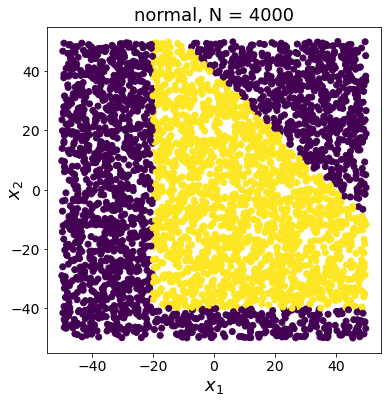

In [ ]:
# N_label identifies the dataset considered in the notebook
# The possibilities are: 'normal', 'increased', 'reduced'
N_label = 'normal'

x = np.loadtxt('./DATA/data-' + N_label + '.dat', delimiter=' ')
y = np.loadtxt('./DATA/labels-' + N_label + '.dat', delimiter=' ')

for i in range(10):
    print(x[i], y[i])

plt.figure(figsize=(6,6))
plt.scatter(x[:,0], x[:,1], c=y, cmap='viridis')
plt.title(N_label + ', N = ' + str(len(x)), fontsize=18)
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18, labelpad=-15)
plt.tick_params(labelsize=14)

plt.show()

### Split training and validation data

In [ ]:
# number of data
N = len(x)
# number of training, validation and test data
perc_train = 0.5
perc_valid = 0.1
N_train = int(perc_train*N)
N_valid = int(perc_valid*N)

x_train, y_train = x[0:N_train], y[0:N_train]
x_valid, y_valid = x[N_train:N_train+N_valid], y[N_train:N_train+N_valid]
x_test, y_test = x[N_train+N_valid:], y[N_train+N_valid:]

print('training:', len(x_train),'\nvalidation:', len(x_valid), '\ntest:', len(x_test))

training: 2000 
validation: 400 
test: 1600


### Augmentation of training set

In [ ]:
# augmentation = True means the training samples are augmented by generating artificial ones
augmentation = False

# augmenting function
def aug(x, y, n=3):

    # box size
    B = 100

    ax = x.copy()
    ay = y.copy()

    # augment data
    for i in range(0, n):
        s = (np.random.random((len(x),2)) - 0.5)*(B/100)
        ax = np.concatenate((ax,x+s), axis=0)
        ay = np.concatenate((ay,y), axis=0)
    
    return ax, ay

if augmentation:
    x_train, y_train = aug(x_train, y_train)
    print('augmented training:', len(x_train))

### Rescale input data

In [ ]:
def Rescale(x):
    return (x-x.mean())/np.sqrt(x.var())

x_train_r = Rescale(x_train)
x_valid_r = Rescale(x_valid)
x_test_r = Rescale(x_test)

### Define the model with Keras

In [ ]:
def create_model(units=[8,8], rate=0, activation='relu', init='he_normal', optimizer='Adam', momentum=0, nesterov=False, learning_rate=0.01):
    
    # create model
    model = Sequential()

    # first hidden layer
    model.add(Dense(units=units[0], activation=activation, kernel_initializer=init, input_dim=2))
    model.add(Dropout(rate))

    # additional hidden layers
    for i in range(len(units)-1):
        model.add(Dense(units=units[i+1], activation=activation, kernel_initializer=init))
        model.add(Dropout(rate))
        
    # output layer
    model.add(Dense(units=1, activation='sigmoid', kernel_initializer='glorot_uniform'))
    
    if optimizer == 'SGD':
        if momentum == 0:
            nesterov = False
        optimizer = SGD(momentum=momentum, nesterov=nesterov, learning_rate=learning_rate)
       
    if optimizer == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)

    if optimizer == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    # compile model    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
model = create_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 24        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________
None


### Training

In [ ]:
# add an early stopping criteria based on the validation accuracy
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=16, verbose=2)
# train the model
fit = model.fit(x_train_r, y_train,
               epochs=128, batch_size=128,
               validation_data=(x_valid_r,y_valid),
               callbacks=[es], verbose=2)

Epoch 1/128
16/16 - 1s - loss: 0.5655 - accuracy: 0.6240 - val_loss: 0.4752 - val_accuracy: 0.7750 - 1s/epoch - 81ms/step
Epoch 2/128
16/16 - 0s - loss: 0.4564 - accuracy: 0.7855 - val_loss: 0.4049 - val_accuracy: 0.8175 - 104ms/epoch - 7ms/step
Epoch 3/128
16/16 - 0s - loss: 0.3939 - accuracy: 0.8350 - val_loss: 0.3418 - val_accuracy: 0.8775 - 113ms/epoch - 7ms/step
Epoch 4/128
16/16 - 0s - loss: 0.3397 - accuracy: 0.8745 - val_loss: 0.2940 - val_accuracy: 0.9125 - 80ms/epoch - 5ms/step
Epoch 5/128
16/16 - 0s - loss: 0.2931 - accuracy: 0.8950 - val_loss: 0.2507 - val_accuracy: 0.9275 - 82ms/epoch - 5ms/step
Epoch 6/128
16/16 - 0s - loss: 0.2530 - accuracy: 0.9115 - val_loss: 0.2147 - val_accuracy: 0.9525 - 74ms/epoch - 5ms/step
Epoch 7/128
16/16 - 0s - loss: 0.2160 - accuracy: 0.9520 - val_loss: 0.1921 - val_accuracy: 0.9225 - 84ms/epoch - 5ms/step
Epoch 8/128
16/16 - 0s - loss: 0.1834 - accuracy: 0.9590 - val_loss: 0.1549 - val_accuracy: 0.9675 - 77ms/epoch - 5ms/step
Epoch 9/128
16/

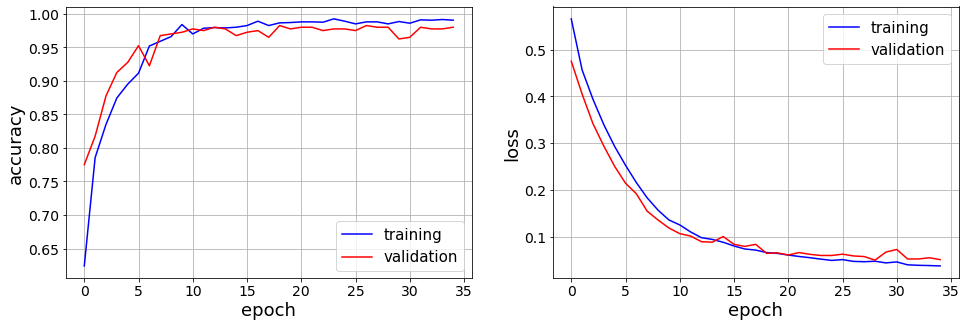

In [ ]:
fig, AX = plt.subplots(1,2,figsize=(16,5))

ax = AX[0]
ax.plot(fit.history['accuracy'], label='training', color='blue')
ax.plot(fit.history['val_accuracy'], label='validation', color='red')
ax.set_xlabel('epoch', fontsize=18, labelpad=3)
ax.set_ylabel('accuracy', fontsize=18, labelpad=3)
ax.legend(fontsize=15)
ax.tick_params(labelsize=14, pad=3)
ax.grid()

ax = AX[1]
ax.plot(fit.history['loss'], label='training', color='blue')
ax.plot(fit.history['val_loss'], label='validation', color='red')
ax.set_xlabel('epoch', fontsize=18, labelpad=3)
ax.set_ylabel('loss', fontsize=18, labelpad=3)
ax.legend(fontsize=15)
ax.tick_params(labelsize=14, pad=3)
ax.grid()

plt.savefig('acc-loss.pdf')
plt.show()

### Weights

In [ ]:
# get weights of the model
for layer in model.layers:
    np.set_printoptions(precision=2)
    if len(layer.get_weights()) > 0:
        print('layer:', layer.get_config())
        print('weights:\n', layer.get_weights()[0])
        print('bias:\n', layer.get_weights()[1], '\n')
    else:
        continue

layer: {'name': 'dense', 'trainable': True, 'batch_input_shape': (None, 2), 'dtype': 'float32', 'units': 8, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
weights:
 [[ 1.16e+00  3.19e-01  1.75e+00 -1.13e+00 -2.60e+00 -1.86e+00  8.41e-01
  -1.12e+00]
 [ 1.16e+00 -2.37e+00  7.09e-01  8.01e-04 -2.66e-01  4.82e-01  1.44e+00
   9.22e-03]]
bias:
 [-1.28 -1.28  0.12 -0.65 -0.93 -0.63 -0.93 -0.64] 

layer: {'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 8, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'ker

### Testing

labels in test set: [0. 1.]
frequencies in test set: [918 682]


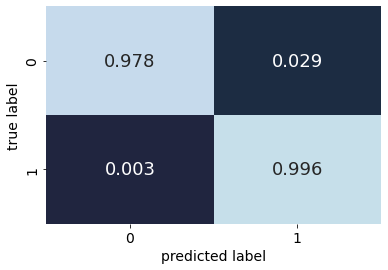

test accuracy: 0.985625


In [ ]:
# predict
pred = model.predict(x_test_r)

# assign each prediction to one of the two classes {0,1}
y_test_hat = np.zeros(len(pred))
y_test_hat[np.where(pred > 0.5)[0]] = 1

labels, freqs = np.unique(y_test, return_counts=True)
print('labels in test set:', labels)
print('frequencies in test set:', freqs)

# confusion matrix
cm = confusion_matrix(y_test, y_test_hat)
cmap = sn.cubehelix_palette(start=1.25, rot=-3, as_cmap=True, reverse=True)
ax = sn.heatmap(np.around(cm/freqs, 3), cmap=cmap, annot=True, cbar=False, fmt='g', annot_kws={'size': 18})
ax.set_xlabel('predicted label', fontsize=14)
ax.set_ylabel('true label', fontsize=14)
plt.tick_params(labelsize=14)
plt.savefig('confusion.pdf')
plt.show()

print('test accuracy:', np.sum(cm[0,0] + cm[1,1])/len(pred))

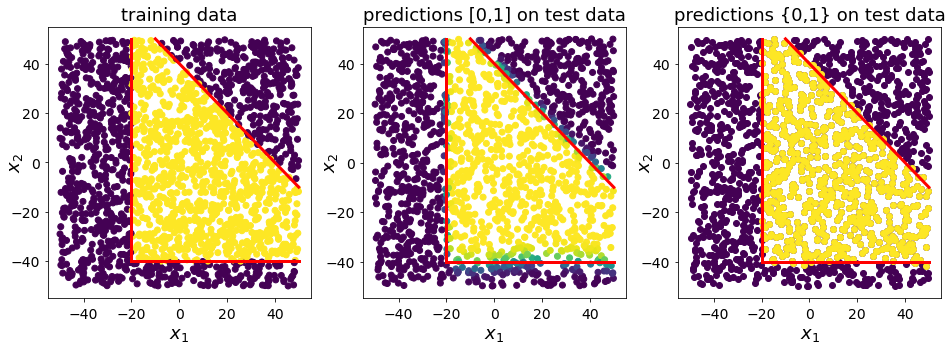

In [ ]:
def boundaries():    
    ax.plot((-20,-20), (-40,50), c='r', lw=3)
    ax.plot((-20,50), (-40,-40), c='r', lw=3)
    ax.plot((-10,50), (50,-10), c='r', lw=3)

fig, AX = plt.subplots(1, 3, figsize=(16,5))

ax = AX[0]
ax.scatter(x_train[:,0], x_train[:,1], c=y_train, cmap='viridis')
ax.set_title('training data', fontsize=18)
ax.set_xlabel('$x_1$', fontsize=18)
ax.set_ylabel('$x_2$', fontsize=18, labelpad=-15)
ax.tick_params(labelsize=14, pad=5)
boundaries()

ax = AX[1]
ax.scatter(x_test[:,0], x_test[:,1], c=pred, cmap='viridis')
ax.set_title('predictions [0,1] on test data', fontsize=18)
ax.set_xlabel('$x_1$', fontsize=18)
ax.set_ylabel('$x_2$', fontsize=18, labelpad=-15)
ax.tick_params(labelsize=14, pad=5)
boundaries()

ax = AX[2]
m = np.where(pred > 0.5)[0] 
ax.scatter(x_test[:,0], x_test[:,1], c='#440154')
ax.scatter(x_test[m,0], x_test[m,1], c='#FDE725')
ax.set_title('predictions {0,1} on test data', fontsize=18)
ax.set_xlabel('$x_1$', fontsize=18)
ax.set_ylabel('$x_2$', fontsize=18, labelpad=-15)
ax.tick_params(labelsize=14, pad=5)
boundaries()

plt.savefig('predictions.pdf')
plt.show()